In [1]:
%matplotlib inline
import xarray as xr
import numpy 
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4
from scipy import stats
import statsmodels.api as sm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
from mpl_toolkits.axes_grid1 import make_axes_locatable
sys.path.append('/Users/gbromley/code/python_utilities/')
from python_data_functions import extract_months
from python_data_functions import mk_test
from python_met_functions import sat_vap_pres
from python_data_functions import mk_test
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText




/Users/gbromley/anaconda/envs/paper1_research/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/gbromley/anaconda/envs/paper1_research/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
data_dir = '/Users/gbromley/data/CRU/'
output_dir='/Users/gbromley/code/NGP_Climate/'
temp_file = 'tmp/cru_ts3.24.1901.2015.tmp.dat.nc'
#vap_file = 'vap/cru_ts3.24.1901.2015.vap.dat.nc'
#nc_vap = xr.open_dataset(data_dir+vap_file)
nc_temp = xr.open_dataset(data_dir+temp_file)


In [3]:
t2m = nc_temp['tmp']


In [37]:
nc_temp

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 1380)
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 -177.8 -177.2 -176.8 ...
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 -87.75 -87.25 -86.75 ...
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 1901-03-16 ...
Data variables:
    tmp      (time, lat, lon) float64 ...
Attributes:
    Conventions:      CF-1.4
    title:            CRU TS3.24 Mean Temperature
    institution:      Data held at British Atmospheric Data Centre, RAL, UK.
    source:           Run ID = 1609301803\nData generated by BADC from:\ntmp....
    history:          Mon 17 Oct 2016 17:28:30 BST : User ianharris : Program...
    references:       Information on the data is available at http://badc.ner...
    comment:          Access to these data is available to any registered CED...
    contact:          BADC <badc@rl.ac.uk>
    acknowledgement:  This update was supported by NERC NCAS and by NERC SMUR...

In [31]:
t_season='AMJ'
t_months=[4,5,6]
start_year = '1970-01-01'
end_year = '2015-12-01'
ext_e = -92
ext_w = -120
ext_n = 55
ext_s = 38
t2m = t2m.sel(lat=slice(ext_s-5,ext_n+5),lon=slice(ext_w-5,ext_e+5))
#ggw_lat,ggw_lon = 48.18, -106.635

In [ ]:
t2m

In [32]:
#extract the time period we are interested in
t2m_slice=t2m.sel(time=slice(start_year,end_year))
#grab the months interested in
t2m_months = t2m_slice.sel(time=extract_months(t2m_slice['time.month'],t_months[0],t_months[-1]))
#create month averages
t2m_months_avg = t2m_months.groupby('time.year').mean(dim='time')

#extract the 30 yr climate normal times
t2m_clim_30= t2m.sel(time=slice('1980-01-01','2011-01-01'))
#grab the months
t2m_clim_months_30 = t2m_clim_30.sel(time=extract_months(t2m_clim_30['time.month'],t_months[0],t_months[-1]))
#create averages over months for climate normal
t2m_clim_months_avg = t2m_clim_months_30.mean(dim='time')

In [ ]:
test = t2m_clim_months_30.groupby('time.month').mean(dim='time')

In [ ]:
len(t2m_months_avg)


In [ ]:
#create 2d structure to hold slope
spatial_trend = t2m.isel(time=1).copy(deep=True)
spatial_trend.name = 't2m_trend'
spatial_trend.attrs['units'] = 'C per Decade'
spatial_trend.attrs['long_name'] = '2 meter temperature trend'


slope_scipy = t2m.isel(time=1).copy(deep=True)
#create 2d structure to hold pvalues
pvalues= t2m.isel(time=1).copy(deep=True)
pvalues.name = 'lag_corr'
pvalues.attrs['units'] = 'pvalues'
pvalues.attrs['long_name'] ='lag 1 autocorrelation'

In [33]:
corr_vals = numpy.arange(0,len(t2m_months_avg))
corr_vals_2 = sm.add_constant(corr_vals)

series = t2m_months_avg[:,30,50]
anom = series - t2m_clim_months_avg[30,50]
test = sm.tsa.stattools.acf(anom)

anom = anom.to_series()


corr_vals = numpy.arange(0,len(anom))
corr_vals_2 = sm.add_constant(corr_vals)
model = sm.OLS(anom.values,corr_vals_2)

model_2 = sm.QuantReg(anom.values, corr_vals_2).fit(q=0.5)


 #slope_2, intercept_2, r_value_2, p_value_2, std_err_2 = stats.linregress(corr_vals,anom.values)
results = model.fit()
residuals = results.resid
#dw = sm.stats.stattools.durbin_watson(residuals)
#slope = results.params[1]
#t_value = ((slope - 0.02)/results.bse[1])
#p_value = stats.t.cdf(t_value, results.df_resid)
# p_value = stats.t.sf(results.tvalues[0], results.df_resid)
#spatial_trend[i,j]=slope*10
        #slope_scipy[i,j] = slope_2*10
#pvalues[i,j]= p_value
        #print(i)

In [34]:
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                      y   Pseudo R-squared:            0.0003802
Model:                       QuantReg   Bandwidth:                       1.752
Method:                 Least Squares   Sparsity:                        3.921
Date:                Wed, 21 Feb 2018   No. Observations:                   46
Time:                        10:40:09   Df Residuals:                       44
                                        Df Model:                            1
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0182      0.569      0.032      0.975      -1.128       1.165
x1            -0.0037      0.022     -0.170      0.866      -0.048       0.040
==============================================================================
"""

In [35]:
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                    0.1636
Date:                Wed, 21 Feb 2018   Prob (F-statistic):              0.688
Time:                        10:40:18   Log-Likelihood:                -79.092
No. Observations:                  46   AIC:                             162.2
Df Residuals:                      44   BIC:                             165.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0461      0.401     -0.115      0.909      -0.853       0.761
x1            -0.0062      0.015     -0.404      0.688      -0.037       0.025
==============================================================================
Omnibus:                        1.648   Durbin-Watson:                   1.772
Prob(Omnibus):                  0.439   Jarque-Bera (JB):                1.052
Skew:                           0.364   Prob(JB):                        0.591
Kurtosis:                       3.140   Cond. No.                         51.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
arma_fit = sm.tsa.ARMA(anom.values, order=[0,0])

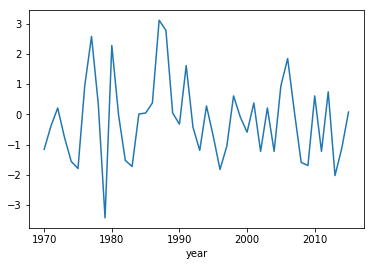

In [36]:
anom.plot()

In [ ]:
test.params

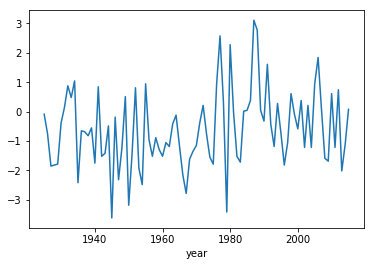

In [7]:
anom.plot()

In [ ]:
sm.tsa.stattools.arma_order_select_ic(anom.values, trend='c',max_ar=6,max_ma=4)

In [23]:
anom_lag = anom.shift(-1)

In [24]:
pre_white = anom - (test[1]*anom_lag)

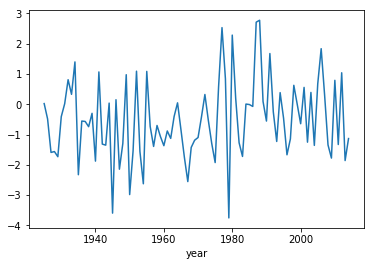

In [29]:
pre_white.plot()

ValueError: all the input array dimensions except for the concatenation axis must match exactly

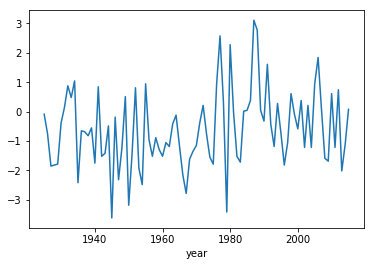

In [30]:
anom.plot()

In [ ]:
plt.hist(anom.values,bins=20,histtype='step')

In [ ]:
pre_white.dropna().values

In [ ]:
#calculate slope and pvalue for each grid point
#replace with a map() call?
corr_vals = np.arange(0,len(t2m_months_avg))
corr_vals_2 = sm.add_constant(corr_vals)
for i in np.arange(0,len(t2m['lat'])):
    for j in np.arange(0,len(t2m['lon'])):
        series = t2m_months_avg[:,i,j]
        anom = series - t2m_clim_months_avg[i,j]
        sm.tsa.stattools.acf(anom)
        model = sm.OLS(anom.values,corr_vals_2)
        #slope_2, intercept_2, r_value_2, p_value_2, std_err_2 = stats.linregress(corr_vals,anom.values)
        results = model.fit()
        slope = results.params[1]
        residuals = results.resid
        dw = sm.stats.stattools.durbin_watson(residuals)
        t_value = ((slope - 0.02)/results.bse[1])
        p_value = stats.t.cdf(t_value, results.df_resid)
       # p_value = stats.t.sf(results.tvalues[0], results.df_resid)
        spatial_trend[i,j]=slope*10
        #slope_scipy[i,j] = slope_2*10
        pvalues[i,j]= dw
        #print(i)

In [ ]:
pvalues.plot()

In [ ]:
series = t2m_months.mean(dim=['lat','lon'])
anom = series.groupby('time.month')-test.mean(dim=['lat','lon'])
anom = anom.to_dataframe()
model = sm.OLS(np.asarray(anom['tmp'].values),np.arange(0,len(anom.index)))
#slope_2, intercept_2, r_value_2, p_value_2, std_err_2 = stats.linregress(x,y)
results = model.fit()
slope = results.params[0]
t_value = ((slope-0.02)/results.bse)
p_value = (stats.t.cdf(t_value, results.df_resid))
#p_value_2 = stats.t.sf(results.tvalues[0],results.df_resid)
#stats.ttest_1samp()
#spatial_trend[i,j]=slope*10
#pvalues[i,j]=p_value 
# - (0.2/10)

In [ ]:
anom['tmp'].rolling(window=3).mean().plot()

In [ ]:
pvals = pvalues.where(pvalues.values < 0.05)

In [ ]:
pvals

In [ ]:
#spatial_trend.to_dataset().to_netcdf(data_dir+'CRU_temp_tobias'+t_season+'_'+'1970'+'.nc')

In [ ]:
pvalues.to_dataset().to_netcdf(t_season+'_1970_pvalues.nc')

In [ ]:
fig = plt.figure(1,figsize=(13,7), dpi=400.0)
projection = ccrs.AlbersEqualArea(central_longitude=-111.0,central_latitude=46.0,false_easting=0.0, false_northing=0.0, standard_parallels=(40.0, 50.0), globe=None)
ax1 = plt.subplot(1,2,1, projection = projection)
#ax1 = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=-111.0,central_latitude=46.0,false_easting=0.0, false_northing=0.0, standard_parallels=(40.0, 50.0), globe=None))
ax1.set_global()
test = spatial_trend.plot.pcolormesh(axes = ax1, transform=ccrs.PlateCarree(),vmin=-0.8, vmax=0.8, cmap='RdBu_r',add_colorbar = False)
#ax = plt.axes(projection=ccrs.LambertConformal())
#pvals.plot.contourf(axes=ax1,transform=ccrs.PlateCarree(),color='none',edgecolor='black',hatches="..",alpha=0.,add_colorbar = False)
ax1.set_extent([ext_e, ext_w, ext_s, ext_n])
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces, edgecolor='lightgray')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS)
#shape_feature = ShapelyFeature(Reader('/Users/gbromley/Dropbox/Montana_Climate_Project/Study_Area/NEON_Domains.shp').geometries(),crs=ccrs.PlateCarree(), facecolor='none',edgecolor='black')
#ax1.add_feature(shape_feature)
#plt.plot(ggw_lon, ggw_lat, axes = ax1, marker='o', markersize = 8, color='black', transform=ccrs.PlateCarree())
#plt.plot(ftp_lon, ftp_lat, axes = ax1, marker='o', markersize = 8, color='black', transform=ccrs.PlateCarree())
#plt.text(ftp_lon+0.5, ftp_lat, 'US-FPe', axes=ax1, color='black', size=8, transform=ccrs.PlateCarree())
#plt.text(ggw_lon-2, ggw_lat, 'GGW', axes=ax1, color='black', size=8, transform=ccrs.PlateCarree())
ax1.title.set_visible(False)
#cb = plt.colorbar(test, cmap='RdBu_r',fraction=0.035)
#cb.set_label('$^\circ$C / Decade',fontsize=10)
#cb.ax.tick_params(labelsize=8)
#plt.text(0, 1,'a', ha='center', va='center', backgroundcolor='lightgray')
#anchored_text = AnchoredText("1", loc=2)
#ax1.add_artist(anchored_text)

#plt.savefig('CRU_temp_no_sig_trends'+t_season+'_1970.png',bbox_inches='tight')
plt.show()
